<a href="https://colab.research.google.com/github/patriani/CNN_CIFAR-10/blob/main/CNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação CIFAR-10 por meio de CNN

In [ ]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Verificar se a GPU está ativa
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU ativa: {device_name}")
else:
    print("Habilite a GPU no Colab para acelerar o treinamento.")


GPU ativa: /device:GPU:0


## Importando dados

Aqui usaremos o dataset CIFAR-10 (https://www.tensorflow.org/datasets/catalog/cifar10?hl=pt-br), que consiste em 60.000 imagens coloridas 32x32 em 10 classes, com 6.000 imagens por classe. Existem 50.000 imagens de treinamento e 10.000 imagens de teste.


In [ ]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Abaixo visualizaremos um dos objetos da amostra em seus 3 canais RBG e por fim a imagem original.

Shape dos objetos: (32, 32, 3)


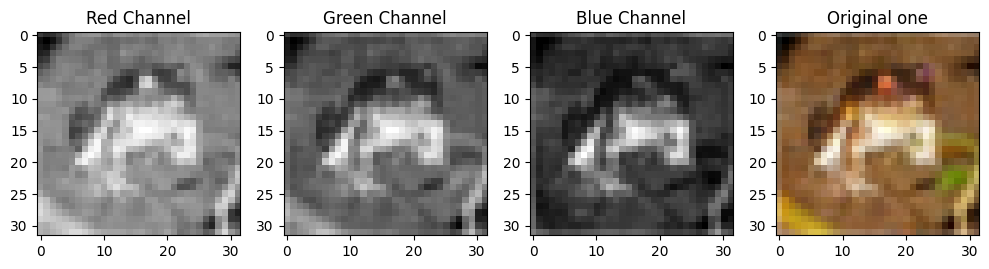

In [ ]:
print(f'Shape dos objetos: {trainX[0].shape}')

# Criar uma figura e um conjunto de subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

# Canal vermelho (R) da imagem original e sua intensidade
axes[0].imshow(trainX[0][:, :, 0], cmap='gray')
axes[0].set_title('Red Channel')

# Canal verde (G) da imagem original e sua intensidade
axes[1].imshow(trainX[0][:, :, 1], cmap='gray')
axes[1].set_title('Green Channel')

# Canal azul (B) da imagem original e sua intensidade
axes[2].imshow(trainX[0][:, :, 2], cmap='gray')
axes[2].set_title('Blue Channel')

# Imagem original (como é apresentada no dataset)
axes[3].imshow(trainX[0])
axes[3].set_title('Original one')

plt.tight_layout()

plt.show()

## Pré-processamento:
Abaixo são apresentados os passos de manipulação das imagens a fim de torná-las compatíveis com o modelo de rede neural.



---



### Observação: Fórmula clássica da Luminância

Inicialmente foi utilizada a fórmula de luminância como parte do pré-processamento, para condensar os três canais presentes na imagem em um único.

- A fórmula de **Luminância** mais comum é:
```Luminância (Y)=0.299⋅R+0.587⋅G+0.114⋅B```

- Sua implementação no **TensorFlow** é dada por:
``` tf.image.rgb_to_grayscale(<data>) ```


**Ps: Esse tratamento dos dados foi removido pois a acurácia do modelo foi prejudicada. O modelo foi adaptado para receber os canais RBG.**

```

print("\n=> Após a conversão para float32:")
print(f'shape do conjunto de treino antes do primeiro reshape: {trainX.shape}')
trainX = tf.image.rgb_to_grayscale(trainX)
testX = tf.image.rgb_to_grayscale(testX)
print(f'shape do conjunto de treino treino depois do rgb_to_grayscale(): {trainX.shape}')


```







### Transformação de uint8 para float32
Convertendo valores dos pixels para float32. Dessa forma normalizaremos sem perda de informações (divisão por 255)



In [ ]:
# Verificando o tipo original dos dados
print("=> Antes da conversão para float32:")
print(f"Tipo de trainX: {trainX.dtype}")
print(f"Exemplo de pixel: {trainX[0, 0, 0]}")  # Mostra o valor de um pixel específico

trainX = trainX.astype('float32')
testX = testX.astype('float32')

# Verificando após a conversão
print("\n=> Após a conversão para float32:")
print(f"Tipo de trainX: {trainX.dtype}")
print(f"Exemplo de pixel: {trainX[0, 0, 0]}")  # O valor deve ser igual, mas agora é float


=> Antes da conversão para float32:
Tipo de trainX: uint8
Exemplo de pixel: [59 62 63]

=> Após a conversão para float32:
Tipo de trainX: float32
Exemplo de pixel: [59. 62. 63.]


### **A normalização reduz esses valores para o intervalo [0, 1], o que:**

  - Acelera o treinamento.
  - Melhora a estabilidade numérica.
  - Evita que valores grandes de entrada causemexplosão de gradiente.
  - Ajuda a convergência mais rápida durante o ajustedos pesos.

In [ ]:
# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0


### **Conversão de rótulos para One-Hot Encoding**
Este método faz com que os rótulos estejam de acordo com o output da softmax, em que é retornado um vetor de probabilidades com soma de 100%.
- Saída da softmax: ``` [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] ```
- Gabarito (100% na posição da classe correta): ``` [0.01, 0.02, 0.90, 0.01, 0.02, 0.01, 0.01, 0.01, 0.00, 0.01] ```

In [ ]:
print(f'trainY antes do to_categorical(): {trainY.shape}')

# transformando a variável alvo (target) para uma codificação one hot
## cada ROTULO da amostra se torna uma linha da matriz e o número de colunas é o numero de classes + 1 <<<<<<<<
trainY = to_categorical(trainY)
testY = to_categorical(testY)

print(f'trainY depois do to_categorical(): {trainY.shape}')

trainY antes do to_categorical(): (50000, 1)
trainY depois do to_categorical(): (50000, 10)


## Construindo o modelo

O modelo proposto pelo exemplo e a ser comparado é o seguinte:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes (dígitos 0 a 9)


Para treinamento do modelo, foi utilizado o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [ ]:
def define_model():
  model = Sequential()

  model.add(layers.RandomFlip("horizontal"))
  model.add(layers.RandomRotation(0.05))
  model.add(layers.RandomZoom(0.05))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

## Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

> Parada prematura:

O ``` tf.keras.callbacks.EarlyStopping ``` é um tipo específico de callback que monitora uma métrica (neste caso, ```val_loss```) e interrompe o treinamento se essa métrica não melhorar por um determinado número de épocas (patience). Ele também pode restaurar os pesos do modelo para aqueles que resultaram no melhor valor da métrica monitorada (```restore_best_weights=True```).

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para como k-folds (cada fold utiliza diferentes subconjuntos de treino e teste)
# train_ix, test_ix: índices que definem os subconjuntos da iteração
for train_ix, test_ix in kfold.split(trainX):

  model = define_model()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target = trainX[train_ix], trainY[train_ix]
  val_data, val_target = trainX[test_ix], trainY[test_ix]

  # Treinando o modelo
  history = model.fit(train_data, train_target,
                      epochs=20, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1, callbacks=[callback])

  # Performance do modelo
  test_loss, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # stores results from each model trained within the k-fold
  scores.append(acc)
  histories.append(history)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2112 - loss: 2.1305 - val_accuracy: 0.4185 - val_loss: 1.5527
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.4105 - loss: 1.5987 - val_accuracy: 0.5271 - val_loss: 1.3190
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4842 - loss: 1.4285 - val_accuracy: 0.5900 - val_loss: 1.1405
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5289 - loss: 1.3211 - val_accuracy: 0.5813 - val_loss: 1.1422
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5562 - loss: 1.2402 - val_accuracy: 0.6340 - val_loss: 1.0223
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5822 - loss: 1.1924 - val_accuracy: 0.6414 - val_loss: 0.9985
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6014 - loss: 1.1468 - val_accuracy: 0.6499 - val_loss: 0.9746
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6084 - lo

Por meio do box-plot apresentado acima é possível observar a dispersão da acurácia do modelo perante diferentes organizações ('splits') do dataset.

<ipython-input-18-14acd54a0822>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


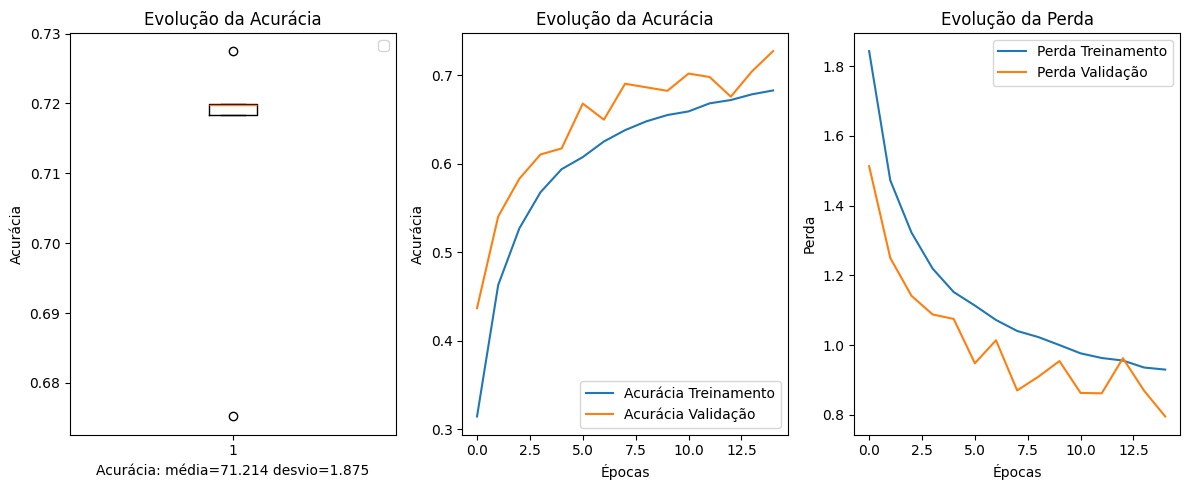

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_9 (RandomFlip)      │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_9               │ (32, 32, 32, 3)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (32, 32, 32, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (32, 32, 32, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (32, 16, 16, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (32, 16, 16, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (32, 16, 16, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (32, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (32, 8, 8, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (32, 8, 8, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (32, 4, 4, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (32, 4, 4, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 2048)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 128)              │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651,712 (6.30 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,101,142 (4.20 MB)

In [ ]:
# Plotando os gráficos de perda e precisão
plt.figure(figsize=(12, 5))


# Box-plot de acurácia no decorrer do k-fold
plt.subplot(1, 3, 1)
plt.boxplot(scores)
plt.xlabel('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')

# Gráfico da precisão
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')

# Gráfico da perda
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Evolução da Perda')

plt.tight_layout()
plt.show()

model.summary()



## Teste e Conclusão

Agora avaliaremos o desempenho do modelo em dados do conjunto de teste separado nas etapas iniciais deste exercício
* Abaixo temos a primeira imagem do conjunto de teste

In [ ]:
# Predição
preds = model.predict(testX)  # shape: (num_amostras, num_classes)

# Extrai o índice com maior probabilidade (classe prevista)
Test_result_vector = np.argmax(preds, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
true_labels = np.argmax(testY, axis=1)

acc = accuracy_score(true_labels, Test_result_vector)
print(f'Acurácia: {acc:.4f}')


Acurácia: 0.7320
